In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, optimize
%matplotlib inline

In [124]:
class SVN:
    def __init__(self, model, *arg):
        self.model = model
        self.DoF = model.DoF
        self.nParticles = 100
        self.nIterations = 100
        self.stepsize = 1
        self.MAP = self.model.getMAP( np.random.normal( size = self.DoF ) )[:,np.newaxis]
        if len(arg) == 0:
            self.resetParticles()
        else:
            self.particles = arg[0]
        
    def apply(self):
        maxmaxshiftold = np.inf
        maxshift = np.zeros(self.nParticles)
        Q = np.zeros( (self.DoF, self.nParticles) )
        for iter_ in range(self.nIterations):
            F = self.model.getForwardModel(self.particles)
            J = self.model.getJacobianForwardModel(self.particles)
            gmlpt  = self.model.getGradientMinusLogPosterior(self.particles, F, J)
            Hmlpt  = self.model.getGNHessianMinusLogPosterior(self.particles, J)
            M = np.mean(Hmlpt, 2)
            
            for i_ in range(self.nParticles):
                sign_diff = self.particles[:,i_,np.newaxis] - self.particles
                Msd   = np.matmul(M, sign_diff)
                kern  = np.exp( - 0.5 * np.sum( sign_diff * Msd, 0 ) )
                gkern = Msd * kern
                
                mgJ = np.mean(- gmlpt * kern + gkern , 1)
                HJ  = np.mean(Hmlpt * kern ** 2, 2) + np.matmul(gkern, gkern.T) / self.nParticles
                Q[:,i_] = np.linalg.solve(HJ, mgJ)
                maxshift[i_] = np.linalg.norm(Q[:,i_], np.inf)
            self.particles += self.stepsize * Q
            maxmaxshift = np.max(maxshift)
            
            if np.isnan(maxmaxshift) or (maxmaxshift > 1e20):
                print('Reset particles...')
                self.resetParticles()
                self.stepsize = 1
            elif maxmaxshift < maxmaxshiftold:
                self.stepsize *= 1.01
            else:
                self.stepsize *= 0.9
            maxmaxshiftold = maxmaxshift
                          
    def resetParticles(self):
        self.particles = np.random.normal( scale = 1, size = (self.DoF, self.nParticles) )

            

In [165]:
class GAUSSIAN():
    def __init__(self):
        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.A    = np.random.normal( size = (self.DoF, 1) )
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()
        
    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.sum(self.A * thetas, 0)
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.matlib.repmat(self.A, 1, nSamples)
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + np.random.normal( scale = self.stdn, size = (1, self.nData) )
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        shift = thetas - self.mu0
        tmp = 0.5 * np.sum( shift ** 2 / self.var0, 0 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)
        shift = F - self.data
        tmp = 0.5 * np.sum( shift ** 2, 0 ) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)
    
    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = (thetas - self.mu0) / self.var0
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)   
        J = arg[1] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J * np.sum(F - self.data, 0) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        J = arg[0] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J.reshape(self.DoF, 1, nSamples) * J.reshape(1, self.DoF, nSamples) / self.varn \
              + (np.eye(self.DoF) / self.var0)[:,:,np.newaxis]
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMAP(self, *arg):
        x0 = arg[0] if len(arg) > 0 else np.random.normal(size = self.DoF)
        res = optimize.minimize(self.getMinusLogPosterior, x0, method='L-BFGS-B')
        return res.x

In [166]:
model = GAUSSIAN()

In [167]:
svn = SVN(model)

In [168]:
svn.apply()

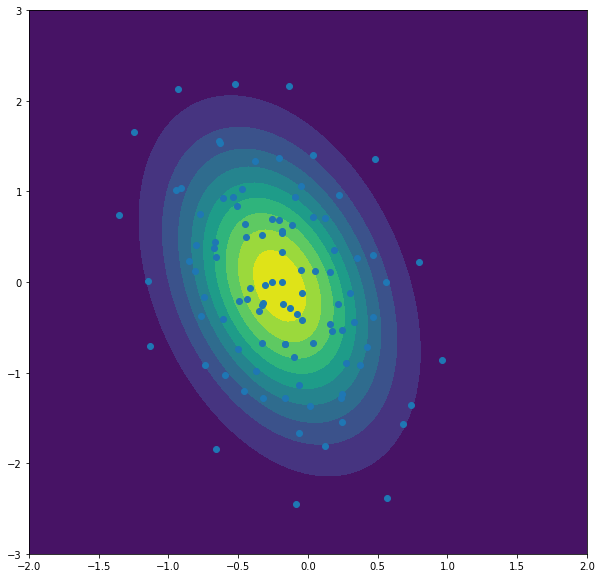

In [170]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-3, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [118]:
class DOUBLEBANANA():
    def __init__(self):
        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()
        
    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.log( ( 1 - thetas[0] ) ** 2 + 100 * ( thetas[1] - thetas[0] ** 2 ) ** 2 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.vstack( ( \
          ( 2 * ( thetas[0,:] - 1 - 200 * thetas[0,:] * (thetas[1,:] - thetas[0,:] ** 2) ) ) \
           / ( 1 + thetas[0,:] ** 2 - 2 * thetas[0,:] + 100 * (thetas[1,:] - thetas[0,:] ** 2) ** 2 ), \
          ( 200 * (thetas[1,:] - thetas[0,:] ** 2) ) \
           / ( 1 + thetas[0,:] ** 2 - 2 * thetas[0,:] + 100 * (thetas[1,:] - thetas[0,:] ** 2) ** 2 ) \
                         ) )
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + np.random.normal( scale = self.stdn, size = (1, self.nData) )
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        shift = thetas - self.mu0
        tmp = 0.5 * np.sum( shift ** 2 / self.var0, 0 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)
        shift = F - self.data
        tmp = 0.5 * np.sum( shift ** 2, 0 ) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)
    
    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = (thetas - self.mu0) / self.var0
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)   
        J = arg[1] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J * np.sum(F - self.data, 0) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        J = arg[0] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J.reshape(self.DoF, 1, nSamples) * J.reshape(1, self.DoF, nSamples) / self.varn \
              + (np.eye(self.DoF) / self.var0)[:,:,np.newaxis]
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMAP(self, *arg):
        x0 = arg[0] if len(arg) > 0 else np.random.normal(size = self.DoF)
        res = optimize.minimize(self.getMinusLogPosterior, x0, method='L-BFGS-B')
        return res.x

In [125]:
model = DOUBLEBANANA()

In [126]:
svn = SVN(model)

In [127]:
svn.apply()

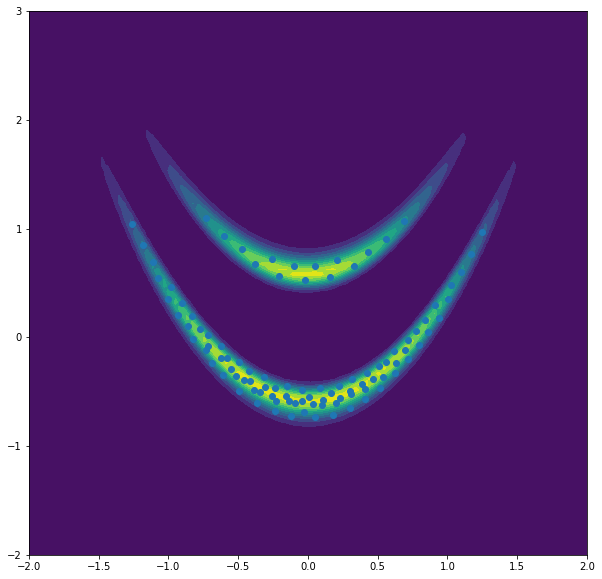

In [128]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])

In [150]:
class NONLINREGRESSION():
    def __init__(self):
        self.DoF = 2
        self.nData = 1
        self.mu0 = np.zeros((self.DoF, 1))
        self.std0 = np.ones((self.DoF,1))
        self.var0 = self.std0 ** 2
        self.stdn = 0.3
        self.varn = self.stdn ** 2
        
        np.random.seed(40)
        self.thetaTrue = np.random.normal(size = self.DoF)
        self.data = self.simulateData()
        
    def getForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = thetas[0] ** 3 + thetas[1]
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getJacobianForwardModel(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = np.vstack( ( 3 * thetas[0] ** 2, np.ones(nSamples) ) )
        return tmp if nSamples > 1 else tmp.squeeze()
        
    def simulateData(self):
        noise = np.random.normal( scale = self.stdn, size = (1, self.nData) )
        return self.getForwardModel(self.thetaTrue) + np.random.normal( scale = self.stdn, size = (1, self.nData) )
        
    def getMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        shift = thetas - self.mu0
        tmp = 0.5 * np.sum( shift ** 2 / self.var0, 0 )
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)
        shift = F - self.data
        tmp = 0.5 * np.sum( shift ** 2, 0 ) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMinusLogPosterior(self, thetas, *arg):
        return self.getMinusLogPrior(thetas) + self.getMinusLogLikelihood(thetas, *arg)
    
    def getGradientMinusLogPrior(self, thetas):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        tmp = (thetas - self.mu0) / self.var0
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogLikelihood(self, thetas, *arg):
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        F = arg[0] if len(arg) > 0 else self.getForwardModel(thetas)   
        J = arg[1] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J * np.sum(F - self.data, 0) / self.varn
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getGradientMinusLogPosterior(self, thetas, *arg):
        return self.getGradientMinusLogPrior(thetas) + self.getGradientMinusLogLikelihood(thetas, *arg)
    
    def getGNHessianMinusLogPosterior(self, thetas, *arg):        
        nSamples = thetas.size // self.DoF
        thetas = thetas.reshape(self.DoF, nSamples)
        J = arg[0] if len(arg) > 1 else self.getJacobianForwardModel(thetas)
        tmp = J.reshape(self.DoF, 1, nSamples) * J.reshape(1, self.DoF, nSamples) / self.varn \
              + (np.eye(self.DoF) / self.var0)[:,:,np.newaxis]
        return tmp if nSamples > 1 else tmp.squeeze()
    
    def getMAP(self, *arg):
        x0 = arg[0] if len(arg) > 0 else np.random.normal(size = self.DoF)
        res = optimize.minimize(self.getMinusLogPosterior, x0, method='L-BFGS-B')
        return res.x

In [151]:
model = NONLINREGRESSION()

In [152]:
svn = SVN(model)

In [153]:
svn.apply()

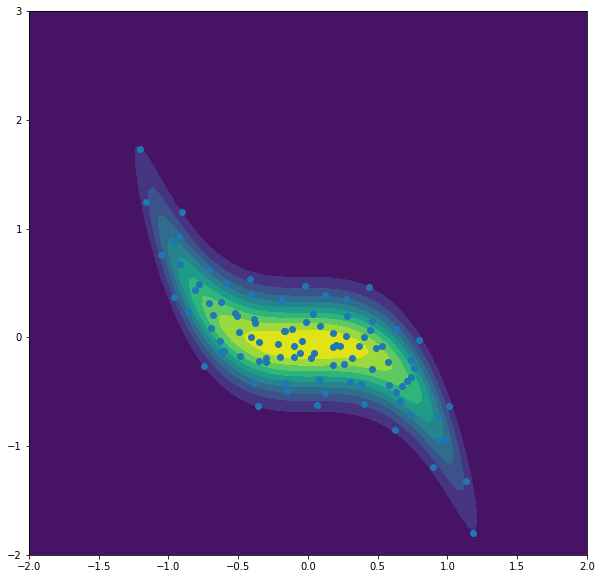

In [154]:
ngrid = 100
x = np.linspace(-2, 2, ngrid)
y = np.linspace(-2, 3, ngrid)
X, Y = np.meshgrid(x,y)
Z = np.exp( - model.getMinusLogPosterior( np.vstack( (np.ndarray.flatten(X), np.ndarray.flatten(Y)) ) ) )\
    .reshape(ngrid, ngrid)

plt.figure(figsize = (10,10))
plt.contourf(X, Y, Z, 10)
plt.scatter(svn.particles[0], svn.particles[1])